In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
print("🚀 Starting Step 1: Installing libraries...")

!pip install "numpy<2" "opencv-python==4.8.0.76" grad-cam -q

print("\n✅ Step 1: Libraries are installed.")

🚀 Starting Step 1: Installing libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [2]:
# Basics
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

# Albumentations (for augmentations)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Sklearn (for K-Fold and metrics)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score

# timm (for pretrained models)
import timm

# Grad-CAM (for "detection"/explainability)
from pytorch_grad_cam import LayerCAM # <-- We will use LayerCAM (it's better)
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import warnings
warnings.filterwarnings('ignore')

# Set random seed
import random
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

print("✅ Step 2: All libraries imported.")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Step 2: All libraries imported.


In [4]:
class CFG:
    IMG_SIZE = 224      # <-- UPDATED to 224
    BATCH_SIZE = 8     # <-- UPDATED to 8 (much faster training)
    LR = 1e-4
    EPOCHS = 30
    SEED = 42
    NUM_CLASSES = 4     # <-- CORRECT (F0, F1, F2, F3)
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    EARLY_STOPPING_PATIENCE = 5
    N_SPLITS = 3

print(f"✅ Step 3: Configuration loaded.")
print(f"   Image Size: {CFG.IMG_SIZE}")
print(f"   Batch Size: {CFG.BATCH_SIZE}")
print(f"   Num Classes: {CFG.NUM_CLASSES}")
print(f"   Device: {CFG.DEVICE}")

✅ Step 3: Configuration loaded.
   Image Size: 224
   Batch Size: 8
   Num Classes: 4
   Device: cuda


Loading data from: /kaggle/input/mri-dataset-224/MRI_T2_224_Combined/
Loading all images from F0, F1, F2, F3 folders...
   ...Found 2185 images in /kaggle/input/mri-dataset-224/MRI_T2_224_Combined/F0
   ...Found 3280 images in /kaggle/input/mri-dataset-224/MRI_T2_224_Combined/F1
   ...Found 3483 images in /kaggle/input/mri-dataset-224/MRI_T2_224_Combined/F2
   ...Found 1906 images in /kaggle/input/mri-dataset-224/MRI_T2_224_Combined/F3

✅ Successfully loaded 10854 total images.
Generating class distribution plot...


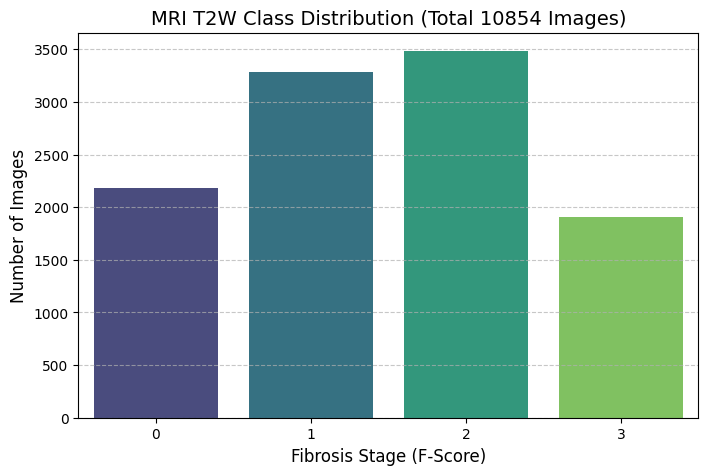


✅ Step 4: Dataset loading complete.


In [5]:
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. SET YOUR MAIN DATA DIRECTORY ---
# This path points to the root of your new MRI dataset
# PLEASE CHECK THIS PATH on your Kaggle Input panel. 
# It might be /kaggle/input/mri-t2-384/MRI_T2_2D_Combined/
data_dir = "/kaggle/input/mri-dataset-224/MRI_T2_224_Combined/" 

# --- 2. DEFINE YOUR CLASSES ---
# We use the 4 classes defined in your CFG
class_map = {
    'F0': 0,
    'F1': 1,
    'F2': 2,
    'F3': 3,
}
print(f"Loading data from: {data_dir}")

# --- 3. WALK THROUGH F-STAGE FOLDERS ---
image_paths = []
labels = []

print("Loading all images from F0, F1, F2, F3 folders...")
for folder_name, class_label in class_map.items():
    folder_path = os.path.join(data_dir, folder_name)
    if not os.path.exists(folder_path):
        print(f"⚠️ Warning: Folder not found, skipping: {folder_path}")
        continue
    
    # Find all .png images
    images_in_folder = glob(os.path.join(folder_path, "*.png"))
    
    for img_path in images_in_folder:
        image_paths.append(img_path)
        labels.append(class_label)
    
    print(f"   ...Found {len(images_in_folder)} images in {folder_path}")

# --- 4. CREATE THE FINAL DATAFRAME ---
df = pd.DataFrame({
    'image_path': image_paths,
    'diagnosis': labels
})

# Shuffle the dataframe
df = df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

print(f"\n✅ Successfully loaded {len(df)} total images.")

# --- 5. PLOT CLASS DISTRIBUTION ---
print("Generating class distribution plot...")
plt.figure(figsize=(8,5))
sns.barplot(
    x=df['diagnosis'].value_counts().sort_index().index,
    y=df['diagnosis'].value_counts().sort_index().values,
    palette='viridis'
)
plt.title(f"MRI T2W Class Distribution (Total {len(df)} Images)", fontsize=14)
plt.xlabel("Fibrosis Stage (F-Score)", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n✅ Step 4: Dataset loading complete.")

🚀 Starting Step 5: Visualizing sample MRI images...


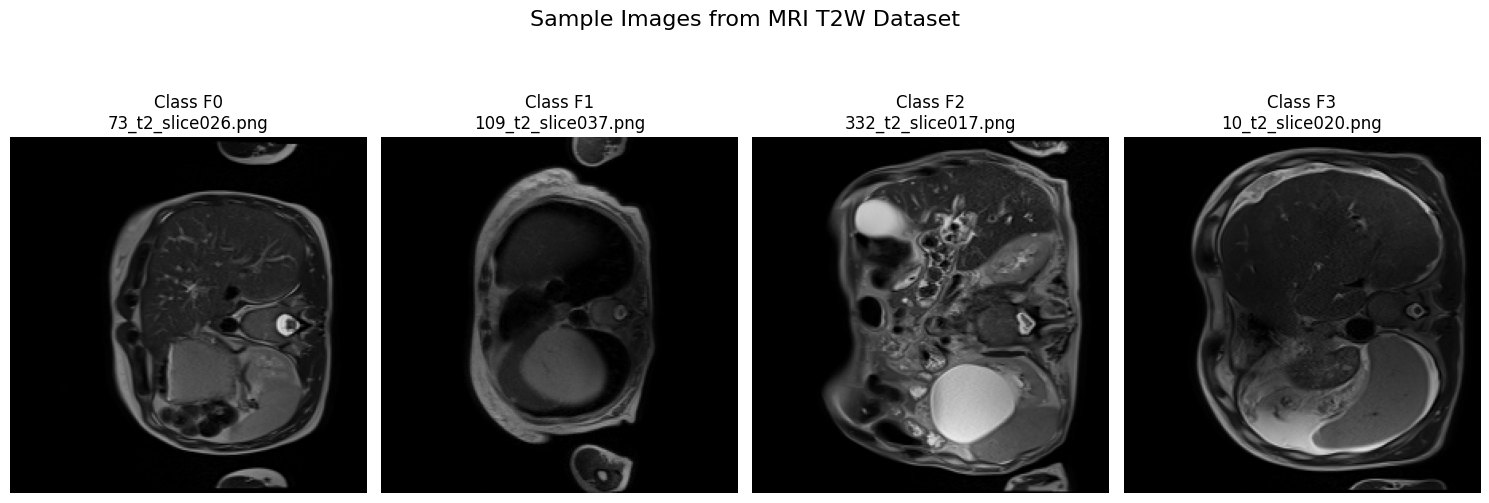


✅ Step 5: Sample images displayed.


In [6]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

print("🚀 Starting Step 5: Visualizing sample MRI images...")

plt.figure(figsize=(15, 6))
# Loop from 0 to 3 (for F0, F1, F2, F3)
for cls in range(CFG.NUM_CLASSES):
    
    # 1. Get one sample row from the dataframe for the current class
    sample_row = df[df['diagnosis'] == cls].sample(1).iloc[0]
    
    # 2. Load the image path
    image_path = sample_row.image_path
    
    # 3. Read the image using cv2
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not load image {image_path}")
        continue
    
    # 4. Plot the image (it's already 3-channel, so no conversion needed)
    plt.subplot(1, CFG.NUM_CLASSES, cls + 1)
    plt.imshow(img, cmap='gray') # Use cmap='gray' for better viewing
    plt.title(f"Class F{cls}\n{os.path.basename(image_path)}") # Show class and filename
    plt.axis("off")

plt.suptitle("Sample Images from MRI T2W Dataset", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Step 5: Sample images displayed.")

In [7]:
import cv2
import numpy as np

# --- Tool 1: CLAHE (for enhancing contrast) ---
def clahe_equalized(img_rgb):
    # Convert to LAB color space
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to the L-channel (brightness)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    
    # Merge the channels back
    lab_clahe = cv2.merge((l_clahe, a, b))
    
    # Convert back to RGB
    return cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

# --- Tool 2: Sharpen (for defining edges) ---
def sharpen(img):
    # This is a standard sharpening kernel
    kernel = np.array([[-1,-1,-1], 
                       [-1, 9,-1], 
                       [-1,-1,-1]])
    return cv2.filter2D(img, -1, kernel)

# --- This is our NEW master function that the model will use ---
def preprocess_for_model(path):
    # 1. Read the image
    img = cv2.imread(path)
    if img is None:
        print(f"Warning: Could not read image {path}")
        return None
    
    # 2. Your images are already 3-channel, but cv2 reads as BGR. Convert to RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    # 3. Reduce image noise
    # A Median Filter is very effective for MRI noise
    img_denoised = cv2.medianBlur(img_rgb, 3) # 3x3 kernel
    
    # 4. Enhance Contrast
    img_clahe = clahe_equalized(img_denoised)
    
    # 5. Sharpen Edges
    img_sharp = sharpen(img_clahe)
    
    return img_sharp

print("✅ Step 6: Advanced preprocessing functions (Denoise, CLAHE, Sharpen) defined.")

✅ Step 6: Advanced preprocessing functions (Denoise, CLAHE, Sharpen) defined.


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# --- 1. Data Augmentations ---
# We use the new 224x224 size
train_tfms = A.Compose([
    A.Resize(height=CFG.IMG_SIZE, width=CFG.IMG_SIZE), # Resizes to 224x224
    A.OneOf([
        A.RandomRotate90(),
        A.Rotate(limit=30),
    ], p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.6),
    A.CoarseDropout(max_holes=8, max_height=CFG.IMG_SIZE//14, max_width=CFG.IMG_SIZE//14, p=0.4),
    A.Normalize(),
    ToTensorV2()
])

valid_tfms = A.Compose([
    A.Resize(height=CFG.IMG_SIZE, width=CFG.IMG_SIZE), # Resizes to 224x224
    A.Normalize(),
    ToTensorV2()
])


# --- 2. Custom PyTorch Dataset ---
# This class uses your new preprocessing function from Step 6
class LiverDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        print(f"Dataset created with {len(self.df)} images.") # Log message

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- This is the key part ---
        # Use our new, advanced function from Step 6
        img = preprocess_for_model(row.image_path) 
        
        if img is None:
            # Handle a bad/missing image
            print(f"Error loading image {row.image_path}, returning dummy data for index {idx}")
            # Create a black image
            img = np.zeros((CFG.IMG_SIZE, CFG.IMG_SIZE, 3), dtype=np.uint8)
            label = torch.tensor(0, dtype=torch.long)
        else:
            # Get the real label
            label = torch.tensor(row.diagnosis, dtype=torch.long)

        # Apply augmentations (Resize, Rotate, Normalize, etc.)
        if self.transform:
            img = self.transform(image=img)["image"]
        
        return img, label

print("✅ Step 7: Augmentations and LiverDataset class defined.")

✅ Step 7: Augmentations and LiverDataset class defined.


In [9]:
import timm
import torch
import torch.nn as nn

# This is your new model class
class HybridDenseViT(nn.Module):
    # We pass CFG.NUM_CLASSES (which is 4) to the init
    def __init__(self, num_classes=CFG.NUM_CLASSES):
        super(HybridDenseViT, self).__init__()
        
        # --- 1. The CNN "Brain" (DenseNet-121) ---
        self.cnn = timm.create_model(
            "densenet121",
            pretrained=True, 
            num_classes=0, # We remove the original classifier head
            global_pool="avg" # This flattens the output to a 1D vector
        )
        
        # --- 2. The Transformer "Brain" (ViT-Base) ---
        # --- THIS IS THE IMPORTANT CHANGE ---
        self.vit = timm.create_model(
            "vit_base_patch16_224", # <-- MUST MATCH your 224x224 image size
            pretrained=True, 
            num_classes=0 # We remove the original classifier head
        )
        
        # --- 3. The "Boss" (Fully Connected Layer) ---
        # This layer combines the features: 1024 (DenseNet) + 768 (ViT)
        self.fc = nn.Linear(
            self.cnn.num_features + self.vit.num_features, 
            num_classes
        )

    def forward(self, x):
        # 1. Get features from both models at the same time
        cnn_feat = self.cnn(x) 
        vit_feat = self.vit(x)
        
        # 2. Combine (fuse) the features
        out = torch.cat([cnn_feat, vit_feat], dim=1)
        
        # 3. Make the final classification (F0-F3)
        out = self.fc(out)
        return out

print("✅ Step 8: HybridDenseViT model class defined.")
print("   (Using 'densenet121' and 'vit_base_patch16_224')")

✅ Step 8: HybridDenseViT model class defined.
   (Using 'densenet121' and 'vit_base_patch16_224')


In [10]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")
    
    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

print("✅ Step 9: FocalLoss function defined. This will help with the imbalanced dataset.")

✅ Step 9: FocalLoss function defined. This will help with the imbalanced dataset.


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, cohen_kappa_score

# Keep track of scores
fold_metrics = []

# --- Start 3-Fold Cross-Validation ---
skf = StratifiedKFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)

print(f"🚀 Starting {CFG.N_SPLITS}-Fold Cross-Validation Training for {CFG.NUM_CLASSES} classes...")

for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df['diagnosis'])):
    print(f"\n===================== FOLD {fold+1}/{CFG.N_SPLITS} =====================")
    
    train_df = df.iloc[train_idx]
    valid_df = df.iloc[valid_idx]
    
    # --- Weighted sampler for imbalanced data ---
    print("Setting up WeightedRandomSampler for imbalanced data...")
    class_counts = train_df['diagnosis'].value_counts().to_dict()
    weights_per_class = {
        cls: 1.0 / count for cls, count in class_counts.items() if count > 0
    }
    weights = [
        weights_per_class.get(i, 0) for i in train_df['diagnosis']
    ]
    sampler = WeightedRandomSampler(
        weights, num_samples=len(weights), replacement=True
    )
    
    # --- Datasets ---
    print("Creating Datasets...")
    train_dataset = LiverDataset(train_df, transform=train_tfms)
    valid_dataset = LiverDataset(valid_df, transform=valid_tfms)
    
    # --- DataLoaders ---
    print("Creating DataLoaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=CFG.BATCH_SIZE, 
        sampler=sampler, # <-- Using the sampler here
        num_workers=2, 
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset, 
        batch_size=CFG.BATCH_SIZE, 
        shuffle=False, 
        num_workers=2,
        pin_memory=True
    )
    
    # --- Model, Criterion, Optimizer, Scheduler ---
    print("Initializing Model, Loss, and Optimizer...")
    model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE) 
    criterion = FocalLoss() # <-- Using your special loss
    optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.5, patience=3, verbose=False 
    )
    
    scaler = GradScaler() # for mixed precision
    
    best_qwk = -1
    no_improve = 0
    
    print(f"--- Starting Training for {CFG.EPOCHS} Epochs ---")
    for epoch in range(CFG.EPOCHS):
        
        # ------------------ TRAIN ------------------
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CFG.EPOCHS} [Train]", leave=False)
        
        for images, labels in train_pbar:
            images = images.to(CFG.DEVICE)
            labels = labels.to(CFG.DEVICE)
            
            optimizer.zero_grad()
            
            with autocast(): # Mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            train_pbar.set_postfix(
                loss=running_loss/total, 
                acc=running_corrects.double().item()/total
            )
        
        train_loss = running_loss / total
        train_acc = running_corrects.double() / total
        
        # ------------------ VALIDATION ------------------
        model.eval()
        val_running_loss = 0.0
        val_total = 0
        all_preds = []
        all_labels = []
        
        valid_pbar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{CFG.EPOCHS} [Valid]", leave=False)
        
        with torch.no_grad():
            for images, labels in valid_pbar:
                images = images.to(CFG.DEVICE)
                labels = labels.to(CFG.DEVICE)
                
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                valid_pbar.set_postfix(
                    loss=val_running_loss/val_total
                )
        
        val_loss = val_running_loss / val_total
        val_acc = accuracy_score(all_labels, all_preds)
        val_qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
        
        scheduler.step(val_qwk) # Step scheduler based on QWK
        
        # --- Print Epoch Summary ---
        print(f"Epoch {epoch+1}/{CFG.EPOCHS} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | ⭐️ Val QWK: {val_qwk:.4f}")
        
        # --- Save best model ---
        if val_qwk > best_qwk:
            best_qwk = val_qwk
            no_improve = 0
            # --- We save with a new name for the MRI model ---
            torch.save(model.state_dict(), f"mri_fold{fold+1}_best_qwk.pth")
            print(f"  🎉 Model Saved! (Best QWK={best_qwk:.4f})")
        else:
            no_improve += 1
            print(f"  (No improvement for {no_improve} epoch(s).)")
        
        if no_improve >= CFG.EARLY_STOPPING_PATIENCE:
            print(f"--- ⚠️ Early stopping triggered after {epoch+1} epochs. ---")
            break
            
    # Store results for this fold
    fold_metrics.append({
        'fold': fold+1,
        'best_qwk': best_qwk
    })
    print(f"--- Finished Fold {fold+1}. Best QWK: {best_qwk:.4f} ---")

print("\n===================================================")
print("✅ Step 10: All training folds are complete.")
print("===================================================")
metrics_df = pd.DataFrame(fold_metrics)
print("\nFinal Model Performance (Best QWK per Fold):")
print(metrics_df)
print(f"\nAverage QWK across all {CFG.N_SPLITS} folds: {metrics_df['best_qwk'].mean():.4f}")


In [12]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np

print("🚀 Starting New Plan: Setting up K-Fold splits...")

# We create our K-Fold splitter
skf = StratifiedKFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)

# We create a list of all our (train_idx, valid_idx) splits
# We will use one of these in each of the next 3 steps
splits = list(skf.split(df, df['diagnosis']))

print(f"✅ Step 10: K-Fold splits are ready. We will now train 3 models in 3 separate steps.")

🚀 Starting New Plan: Setting up K-Fold splits...
✅ Step 10: K-Fold splits are ready. We will now train 3 models in 3 separate steps.


In [13]:
import torch
import gc
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, cohen_kappa_score

print("\n===================== 🚀 STARTING FOLD 1/3 =====================")

# --- 1. Get the indexes for Fold 1 ---
fold_to_run = 0
train_idx, valid_idx = splits[fold_to_run]

train_df = df.iloc[train_idx]
valid_df = df.iloc[valid_idx]

# --- 2. Weighted sampler ---
print("Setting up WeightedRandomSampler...")
class_counts = train_df['diagnosis'].value_counts().to_dict()
weights_per_class = {cls: 1.0 / count for cls, count in class_counts.items() if count > 0}
weights = [weights_per_class.get(i, 0) for i in train_df['diagnosis']]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# --- 3. Datasets & DataLoaders ---
print("Creating Datasets and DataLoaders...")
train_dataset = LiverDataset(train_df, transform=train_tfms)
valid_dataset = LiverDataset(valid_df, transform=valid_tfms)

train_loader = DataLoader(
    train_dataset, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

# --- 4. Model, Loss, Optimizer ---
print("Initializing Model, Loss, and Optimizer...")
# Clear any old models from memory
model = None
gc.collect()
torch.cuda.empty_cache()
model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE) 
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3, verbose=False 
)
scaler = GradScaler()
best_qwk = -1
no_improve = 0

# --- 5. Start Training Loop for Fold 1 ---
print(f"--- Starting Training for {CFG.EPOCHS} Epochs ---")
for epoch in range(CFG.EPOCHS):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Fold 1 - Epoch {epoch+1}/{CFG.EPOCHS} [Train]", leave=False)
    
    for images, labels in train_pbar:
        images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images); loss = criterion(outputs, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data); total += labels.size(0)
        train_pbar.set_postfix(loss=running_loss/total, acc=running_corrects.double().item()/total)
    
    train_loss, train_acc = running_loss / total, running_corrects.double() / total
    
    model.eval()
    val_running_loss, val_total = 0.0, 0
    all_preds, all_labels = [], []
    valid_pbar = tqdm(valid_loader, desc=f"Fold 1 - Epoch {epoch+1}/{CFG.EPOCHS} [Valid]", leave=False)
    
    with torch.no_grad():
        for images, labels in valid_pbar:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            with autocast():
                outputs = model(images); loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            valid_pbar.set_postfix(loss=val_running_loss/val_total)
            
    val_loss = val_running_loss / val_total
    val_acc = accuracy_score(all_labels, all_preds)
    val_qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
    scheduler.step(val_qwk)
    
    print(f"Epoch {epoch+1}/{CFG.EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | ⭐️ Val QWK: {val_qwk:.4f}")
    
    if val_qwk > best_qwk:
        best_qwk = val_qwk; no_improve = 0
        torch.save(model.state_dict(), f"mri_fold{fold_to_run+1}_best_qwk.pth")
        print(f"  🎉 Model Saved! (Best QWK={best_qwk:.4f})")
    else:
        no_improve += 1
        print(f"  (No improvement for {no_improve} epoch(s).)")
    
    if no_improve >= CFG.EARLY_STOPPING_PATIENCE:
        print(f"--- ⚠️ Early stopping triggered after {epoch+1} epochs. ---")
        break
        
print(f"\n✅ Step 11: FOLD 1/3 COMPLETE. Best QWK: {best_qwk:.4f}")
print("Your model 'mri_fold1_best_qwk.pth' is now saved.")


===================== 🚀 STARTING FOLD 1/3 =====================
Setting up WeightedRandomSampler...
Creating Datasets and DataLoaders...
Dataset created with 7236 images.
Dataset created with 3618 images.
Initializing Model, Loss, and Optimizer...


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

--- Starting Training for 30 Epochs ---


Epoch 1/30 Summary:
  Train Loss: 0.5799 | Train Acc: 0.4907
  Val   Loss: 0.4909 | Val   Acc: 0.5473 | ⭐️ Val QWK: 0.6846
  🎉 Model Saved! (Best QWK=0.6846)


Epoch 2/30 Summary:
  Train Loss: 0.4483 | Train Acc: 0.5920
  Val   Loss: 0.3231 | Val   Acc: 0.6658 | ⭐️ Val QWK: 0.7516
  🎉 Model Saved! (Best QWK=0.7516)


Epoch 3/30 Summary:
  Train Loss: 0.3715 | Train Acc: 0.6549
  Val   Loss: 0.2590 | Val   Acc: 0.7449 | ⭐️ Val QWK: 0.8105
  🎉 Model Saved! (Best QWK=0.8105)


Epoch 4/30 Summary:
  Train Loss: 0.3180 | Train Acc: 0.7001
  Val   Loss: 0.2706 | Val   Acc: 0.7217 | ⭐️ Val QWK: 0.8140
  🎉 Model Saved! (Best QWK=0.8140)


Epoch 5/30 Summary:
  Train Loss: 0.2834 | Train Acc: 0.7295
  Val   Loss: 0.2084 | Val   Acc: 0.7695 | ⭐️ Val QWK: 0.8392
  🎉 Model Saved! (Best QWK=0.8392)


Epoch 6/30 Summary:
  Train Loss: 0.2576 | Train Acc: 0.7565
  Val   Loss: 0.2355 | Val   Acc: 0.7501 | ⭐️ Val QWK: 0.8239
  (No improvement for 1 epoch(s).)


Epoch 7/30 Summary:
  Train Loss: 0.2274 | Train Acc: 0.7783
  Val   Loss: 0.1827 | Val   Acc: 0.7985 | ⭐️ Val QWK: 0.8630
  🎉 Model Saved! (Best QWK=0.8630)


Epoch 8/30 Summary:
  Train Loss: 0.2073 | Train Acc: 0.7967
  Val   Loss: 0.1411 | Val   Acc: 0.8444 | ⭐️ Val QWK: 0.8914
  🎉 Model Saved! (Best QWK=0.8914)


Epoch 9/30 Summary:
  Train Loss: 0.1952 | Train Acc: 0.8072
  Val   Loss: 0.1507 | Val   Acc: 0.8350 | ⭐️ Val QWK: 0.8859
  (No improvement for 1 epoch(s).)


Epoch 10/30 Summary:
  Train Loss: 0.1680 | Train Acc: 0.8315
  Val   Loss: 0.1192 | Val   Acc: 0.8798 | ⭐️ Val QWK: 0.9105
  🎉 Model Saved! (Best QWK=0.9105)


Epoch 11/30 Summary:
  Train Loss: 0.1605 | Train Acc: 0.8364
  Val   Loss: 0.1049 | Val   Acc: 0.8856 | ⭐️ Val QWK: 0.9111
  🎉 Model Saved! (Best QWK=0.9111)


Epoch 12/30 Summary:
  Train Loss: 0.1509 | Train Acc: 0.8520
  Val   Loss: 0.1310 | Val   Acc: 0.8654 | ⭐️ Val QWK: 0.9030
  (No improvement for 1 epoch(s).)


Epoch 13/30 Summary:
  Train Loss: 0.1371 | Train Acc: 0.8585
  Val   Loss: 0.1338 | Val   Acc: 0.8626 | ⭐️ Val QWK: 0.9017
  (No improvement for 2 epoch(s).)


Epoch 14/30 Summary:
  Train Loss: 0.1253 | Train Acc: 0.8693
  Val   Loss: 0.0936 | Val   Acc: 0.8964 | ⭐️ Val QWK: 0.9350
  🎉 Model Saved! (Best QWK=0.9350)


Epoch 15/30 Summary:
  Train Loss: 0.1310 | Train Acc: 0.8691
  Val   Loss: 0.0820 | Val   Acc: 0.9116 | ⭐️ Val QWK: 0.9378
  🎉 Model Saved! (Best QWK=0.9378)


Epoch 16/30 Summary:
  Train Loss: 0.1129 | Train Acc: 0.8847
  Val   Loss: 0.0841 | Val   Acc: 0.9069 | ⭐️ Val QWK: 0.9373
  (No improvement for 1 epoch(s).)


Epoch 17/30 Summary:
  Train Loss: 0.1077 | Train Acc: 0.8886
  Val   Loss: 0.0911 | Val   Acc: 0.9019 | ⭐️ Val QWK: 0.9287
  (No improvement for 2 epoch(s).)


Epoch 18/30 Summary:
  Train Loss: 0.1045 | Train Acc: 0.8892
  Val   Loss: 0.0738 | Val   Acc: 0.9190 | ⭐️ Val QWK: 0.9479
  🎉 Model Saved! (Best QWK=0.9479)


Epoch 19/30 Summary:
  Train Loss: 0.0955 | Train Acc: 0.9001
  Val   Loss: 0.0754 | Val   Acc: 0.9176 | ⭐️ Val QWK: 0.9427
  (No improvement for 1 epoch(s).)


Epoch 20/30 Summary:
  Train Loss: 0.0875 | Train Acc: 0.9064
  Val   Loss: 0.0862 | Val   Acc: 0.9193 | ⭐️ Val QWK: 0.9384
  (No improvement for 2 epoch(s).)


Epoch 21/30 Summary:
  Train Loss: 0.0854 | Train Acc: 0.9077
  Val   Loss: 0.1327 | Val   Acc: 0.8731 | ⭐️ Val QWK: 0.9156
  (No improvement for 3 epoch(s).)


Epoch 22/30 Summary:
  Train Loss: 0.0792 | Train Acc: 0.9169
  Val   Loss: 0.1063 | Val   Acc: 0.8977 | ⭐️ Val QWK: 0.9296
  (No improvement for 4 epoch(s).)


Epoch 23/30 Summary:
  Train Loss: 0.0576 | Train Acc: 0.9367
  Val   Loss: 0.0408 | Val   Acc: 0.9605 | ⭐️ Val QWK: 0.9698
  🎉 Model Saved! (Best QWK=0.9698)


Epoch 24/30 Summary:
  Train Loss: 0.0486 | Train Acc: 0.9438
  Val   Loss: 0.0320 | Val   Acc: 0.9652 | ⭐️ Val QWK: 0.9741
  🎉 Model Saved! (Best QWK=0.9741)


Epoch 25/30 Summary:
  Train Loss: 0.0436 | Train Acc: 0.9519
  Val   Loss: 0.0584 | Val   Acc: 0.9420 | ⭐️ Val QWK: 0.9565
  (No improvement for 1 epoch(s).)


Epoch 26/30 Summary:
  Train Loss: 0.0450 | Train Acc: 0.9505
  Val   Loss: 0.0367 | Val   Acc: 0.9616 | ⭐️ Val QWK: 0.9725
  (No improvement for 2 epoch(s).)


Epoch 27/30 Summary:
  Train Loss: 0.0404 | Train Acc: 0.9583
  Val   Loss: 0.0359 | Val   Acc: 0.9655 | ⭐️ Val QWK: 0.9770
  🎉 Model Saved! (Best QWK=0.9770)


Epoch 28/30 Summary:
  Train Loss: 0.0410 | Train Acc: 0.9569
  Val   Loss: 0.0389 | Val   Acc: 0.9646 | ⭐️ Val QWK: 0.9731
  (No improvement for 1 epoch(s).)


Epoch 29/30 Summary:
  Train Loss: 0.0378 | Train Acc: 0.9608
  Val   Loss: 0.0297 | Val   Acc: 0.9699 | ⭐️ Val QWK: 0.9788
  🎉 Model Saved! (Best QWK=0.9788)


Epoch 30/30 Summary:
  Train Loss: 0.0370 | Train Acc: 0.9623
  Val   Loss: 0.0340 | Val   Acc: 0.9635 | ⭐️ Val QWK: 0.9727
  (No improvement for 1 epoch(s).)

✅ Step 11: FOLD 1/3 COMPLETE. Best QWK: 0.9788
Your model 'mri_fold1_best_qwk.pth' is now saved.


In [14]:
import torch
import gc
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, cohen_kappa_score

print("\n===================== 🚀 STARTING FOLD 2/3 =====================")

# --- 1. Get the indexes for Fold 2 ---
fold_to_run = 1  # <-- THIS IS THE ONLY CHANGE
train_idx, valid_idx = splits[fold_to_run]

train_df = df.iloc[train_idx]
valid_df = df.iloc[valid_idx]

# --- 2. Weighted sampler ---
print("Setting up WeightedRandomSampler...")
class_counts = train_df['diagnosis'].value_counts().to_dict()
weights_per_class = {cls: 1.0 / count for cls, count in class_counts.items() if count > 0}
weights = [weights_per_class.get(i, 0) for i in train_df['diagnosis']]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# --- 3. Datasets & DataLoaders ---
print("Creating Datasets and DataLoaders...")
train_dataset = LiverDataset(train_df, transform=train_tfms)
valid_dataset = LiverDataset(valid_df, transform=valid_tfms)

train_loader = DataLoader(
    train_dataset, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

# --- 4. Model, Loss, Optimizer ---
print("Initializing Model, Loss, and Optimizer...")
# Clear any old models from memory
model = None
gc.collect()
torch.cuda.empty_cache()
model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE) 
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3, verbose=False 
)
scaler = GradScaler()
best_qwk = -1
no_improve = 0

# --- 5. Start Training Loop for Fold 2 ---
print(f"--- Starting Training for {CFG.EPOCHS} Epochs ---")
for epoch in range(CFG.EPOCHS):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Fold 2 - Epoch {epoch+1}/{CFG.EPOCHS} [Train]", leave=False) # <-- Updated text
    
    for images, labels in train_pbar:
        images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images); loss = criterion(outputs, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data); total += labels.size(0)
        train_pbar.set_postfix(loss=running_loss/total, acc=running_corrects.double().item()/total)
    
    train_loss, train_acc = running_loss / total, running_corrects.double() / total
    
    model.eval()
    val_running_loss, val_total = 0.0, 0
    all_preds, all_labels = [], []
    valid_pbar = tqdm(valid_loader, desc=f"Fold 2 - Epoch {epoch+1}/{CFG.EPOCHS} [Valid]", leave=False) # <-- Updated text
    
    with torch.no_grad():
        for images, labels in valid_pbar:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            with autocast():
                outputs = model(images); loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            valid_pbar.set_postfix(loss=val_running_loss/val_total)
            
    val_loss = val_running_loss / val_total
    val_acc = accuracy_score(all_labels, all_preds)
    val_qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
    scheduler.step(val_qwk)
    
    print(f"Epoch {epoch+1}/{CFG.EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | ⭐️ Val QWK: {val_qwk:.4f}")
    
    if val_qwk > best_qwk:
        best_qwk = val_qwk; no_improve = 0
        torch.save(model.state_dict(), f"mri_fold{fold_to_run+1}_best_qwk.pth") # <-- Saves as mri_fold2_...
        print(f"  🎉 Model Saved! (Best QWK={best_qwk:.4f})")
    else:
        no_improve += 1
        print(f"  (No improvement for {no_improve} epoch(s).)")
    
    if no_improve >= CFG.EARLY_STOPPING_PATIENCE:
        print(f"--- ⚠️ Early stopping triggered after {epoch+1} epochs. ---")
        break
        
print(f"\n✅ Step 12: FOLD 2/3 COMPLETE. Best QWK: {best_qwk:.4f}")
print("Your model 'mri_fold2_best_qwk.pth' is now saved.")


===================== 🚀 STARTING FOLD 2/3 =====================
Setting up WeightedRandomSampler...
Creating Datasets and DataLoaders...
Dataset created with 7236 images.
Dataset created with 3618 images.
Initializing Model, Loss, and Optimizer...
--- Starting Training for 30 Epochs ---


Epoch 1/30 Summary:
  Train Loss: 0.5652 | Train Acc: 0.5100
  Val   Loss: 0.4252 | Val   Acc: 0.6050 | ⭐️ Val QWK: 0.6964
  🎉 Model Saved! (Best QWK=0.6964)


Epoch 2/30 Summary:
  Train Loss: 0.4105 | Train Acc: 0.6222
  Val   Loss: 0.4330 | Val   Acc: 0.6097 | ⭐️ Val QWK: 0.7210
  🎉 Model Saved! (Best QWK=0.7210)


Epoch 3/30 Summary:
  Train Loss: 0.3534 | Train Acc: 0.6708
  Val   Loss: 0.2686 | Val   Acc: 0.7297 | ⭐️ Val QWK: 0.8026
  🎉 Model Saved! (Best QWK=0.8026)


Epoch 4/30 Summary:
  Train Loss: 0.3154 | Train Acc: 0.7056
  Val   Loss: 0.2225 | Val   Acc: 0.7758 | ⭐️ Val QWK: 0.8366
  🎉 Model Saved! (Best QWK=0.8366)


Epoch 5/30 Summary:
  Train Loss: 0.2805 | Train Acc: 0.7313
  Val   Loss: 0.2235 | Val   Acc: 0.7750 | ⭐️ Val QWK: 0.8333
  (No improvement for 1 epoch(s).)


Epoch 6/30 Summary:
  Train Loss: 0.2434 | Train Acc: 0.7633
  Val   Loss: 0.2542 | Val   Acc: 0.7507 | ⭐️ Val QWK: 0.8202
  (No improvement for 2 epoch(s).)


Epoch 7/30 Summary:
  Train Loss: 0.2275 | Train Acc: 0.7745
  Val   Loss: 0.1845 | Val   Acc: 0.8107 | ⭐️ Val QWK: 0.8749
  🎉 Model Saved! (Best QWK=0.8749)


Epoch 8/30 Summary:
  Train Loss: 0.2053 | Train Acc: 0.7974
  Val   Loss: 0.1741 | Val   Acc: 0.8217 | ⭐️ Val QWK: 0.8769
  🎉 Model Saved! (Best QWK=0.8769)


Epoch 9/30 Summary:
  Train Loss: 0.1834 | Train Acc: 0.8184
  Val   Loss: 0.1266 | Val   Acc: 0.8626 | ⭐️ Val QWK: 0.9099
  🎉 Model Saved! (Best QWK=0.9099)


Epoch 10/30 Summary:
  Train Loss: 0.1651 | Train Acc: 0.8335
  Val   Loss: 0.1218 | Val   Acc: 0.8753 | ⭐️ Val QWK: 0.9114
  🎉 Model Saved! (Best QWK=0.9114)


Epoch 11/30 Summary:
  Train Loss: 0.1598 | Train Acc: 0.8367
  Val   Loss: 0.1329 | Val   Acc: 0.8723 | ⭐️ Val QWK: 0.8957
  (No improvement for 1 epoch(s).)


Epoch 12/30 Summary:
  Train Loss: 0.1414 | Train Acc: 0.8561
  Val   Loss: 0.1087 | Val   Acc: 0.8928 | ⭐️ Val QWK: 0.9252
  🎉 Model Saved! (Best QWK=0.9252)


Epoch 13/30 Summary:
  Train Loss: 0.1329 | Train Acc: 0.8672
  Val   Loss: 0.1222 | Val   Acc: 0.8762 | ⭐️ Val QWK: 0.9087
  (No improvement for 1 epoch(s).)


Epoch 14/30 Summary:
  Train Loss: 0.1259 | Train Acc: 0.8720
  Val   Loss: 0.1000 | Val   Acc: 0.9046 | ⭐️ Val QWK: 0.9381
  🎉 Model Saved! (Best QWK=0.9381)


Epoch 15/30 Summary:
  Train Loss: 0.1188 | Train Acc: 0.8816
  Val   Loss: 0.0974 | Val   Acc: 0.9011 | ⭐️ Val QWK: 0.9319
  (No improvement for 1 epoch(s).)


Epoch 16/30 Summary:
  Train Loss: 0.1153 | Train Acc: 0.8818
  Val   Loss: 0.0848 | Val   Acc: 0.9160 | ⭐️ Val QWK: 0.9435
  🎉 Model Saved! (Best QWK=0.9435)


Epoch 17/30 Summary:
  Train Loss: 0.1042 | Train Acc: 0.8893
  Val   Loss: 0.0812 | Val   Acc: 0.9146 | ⭐️ Val QWK: 0.9436
  🎉 Model Saved! (Best QWK=0.9436)


Epoch 18/30 Summary:
  Train Loss: 0.0978 | Train Acc: 0.9005
  Val   Loss: 0.0567 | Val   Acc: 0.9378 | ⭐️ Val QWK: 0.9583
  🎉 Model Saved! (Best QWK=0.9583)


Epoch 19/30 Summary:
  Train Loss: 0.0929 | Train Acc: 0.9020
  Val   Loss: 0.1011 | Val   Acc: 0.9013 | ⭐️ Val QWK: 0.9254
  (No improvement for 1 epoch(s).)


Epoch 20/30 Summary:
  Train Loss: 0.0899 | Train Acc: 0.9052
  Val   Loss: 0.0669 | Val   Acc: 0.9342 | ⭐️ Val QWK: 0.9495
  (No improvement for 2 epoch(s).)


Epoch 21/30 Summary:
  Train Loss: 0.0871 | Train Acc: 0.9129
  Val   Loss: 0.0488 | Val   Acc: 0.9514 | ⭐️ Val QWK: 0.9656
  🎉 Model Saved! (Best QWK=0.9656)


Epoch 22/30 Summary:
  Train Loss: 0.0763 | Train Acc: 0.9183
  Val   Loss: 0.0643 | Val   Acc: 0.9359 | ⭐️ Val QWK: 0.9548
  (No improvement for 1 epoch(s).)


Epoch 23/30 Summary:
  Train Loss: 0.0743 | Train Acc: 0.9208
  Val   Loss: 0.0684 | Val   Acc: 0.9339 | ⭐️ Val QWK: 0.9545
  (No improvement for 2 epoch(s).)


Epoch 24/30 Summary:
  Train Loss: 0.0720 | Train Acc: 0.9232
  Val   Loss: 0.0690 | Val   Acc: 0.9362 | ⭐️ Val QWK: 0.9515
  (No improvement for 3 epoch(s).)


Epoch 25/30 Summary:
  Train Loss: 0.0694 | Train Acc: 0.9236
  Val   Loss: 0.0700 | Val   Acc: 0.9386 | ⭐️ Val QWK: 0.9494
  (No improvement for 4 epoch(s).)


Epoch 26/30 Summary:
  Train Loss: 0.0485 | Train Acc: 0.9508
  Val   Loss: 0.0374 | Val   Acc: 0.9668 | ⭐️ Val QWK: 0.9722
  🎉 Model Saved! (Best QWK=0.9722)


Epoch 27/30 Summary:
  Train Loss: 0.0378 | Train Acc: 0.9598
  Val   Loss: 0.0257 | Val   Acc: 0.9746 | ⭐️ Val QWK: 0.9791
  🎉 Model Saved! (Best QWK=0.9791)


Epoch 28/30 Summary:
  Train Loss: 0.0384 | Train Acc: 0.9601
  Val   Loss: 0.0260 | Val   Acc: 0.9740 | ⭐️ Val QWK: 0.9807
  🎉 Model Saved! (Best QWK=0.9807)


Epoch 29/30 Summary:
  Train Loss: 0.0363 | Train Acc: 0.9619
  Val   Loss: 0.0260 | Val   Acc: 0.9748 | ⭐️ Val QWK: 0.9805
  (No improvement for 1 epoch(s).)


Epoch 30/30 Summary:
  Train Loss: 0.0336 | Train Acc: 0.9643
  Val   Loss: 0.0383 | Val   Acc: 0.9646 | ⭐️ Val QWK: 0.9767
  (No improvement for 2 epoch(s).)

✅ Step 12: FOLD 2/3 COMPLETE. Best QWK: 0.9807
Your model 'mri_fold2_best_qwk.pth' is now saved.


In [15]:
import os
from IPython.display import FileLink

print("🚀 Starting Step 12.5: Saving your progress...")
zip_file_name = "mri_models_fold1-2.zip"
files_to_save = [
    "mri_fold1_best_qwk.pth",
    "mri_fold2_best_qwk.pth"
]

# Check which files actually exist
existing_files = [f for f in files_to_save if os.path.exists(f)]

if len(existing_files) == 2:
    # Create the zip command
    zip_command = f"zip -r {zip_file_name} {' '.join(existing_files)}"
    
    print(f"Zipping {len(existing_files)} model files...")
    # Run the zip command in the terminal
    !{zip_command}
    
    print(f"\n✅ Zip file '{zip_file_name}' created successfully!")
    print("---")
    print("👇👇👇 DOWNLOAD THIS FILE NOW! 👇👇👇")
    print("This is your backup. Save it to your computer.")
    display(FileLink(zip_file_name))
else:
    print("⚠️ ERROR: Could not find both 'mri_fold1_best_qwk.pth' and 'mri_fold2_best_qwk.pth'.")

🚀 Starting Step 12.5: Saving your progress...
Zipping 2 model files...
  adding: mri_fold1_best_qwk.pth (deflated 7%)
  adding: mri_fold2_best_qwk.pth (deflated 7%)

✅ Zip file 'mri_models_fold1-2.zip' created successfully!
---
👇👇👇 DOWNLOAD THIS FILE NOW! 👇👇👇
This is your backup. Save it to your computer.


/kaggle/working/mri_models_fold1-2.zip

In [16]:
import torch
import gc
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, cohen_kappa_score

print("\n===================== 🚀 STARTING FOLD 3/3 =====================")

# --- 1. Get the indexes for Fold 3 ---
fold_to_run = 2  # <-- THIS IS THE ONLY CHANGE
train_idx, valid_idx = splits[fold_to_run]

train_df = df.iloc[train_idx]
valid_df = df.iloc[valid_idx]

# --- 2. Weighted sampler ---
print("Setting up WeightedRandomSampler...")
class_counts = train_df['diagnosis'].value_counts().to_dict()
weights_per_class = {cls: 1.0 / count for cls, count in class_counts.items() if count > 0}
weights = [weights_per_class.get(i, 0) for i in train_df['diagnosis']]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# --- 3. Datasets & DataLoaders ---
print("Creating Datasets and DataLoaders...")
train_dataset = LiverDataset(train_df, transform=train_tfms)
valid_dataset = LiverDataset(valid_df, transform=valid_tfms)

train_loader = DataLoader(
    train_dataset, batch_size=CFG.BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

# --- 4. Model, Loss, Optimizer ---
print("Initializing Model, Loss, and Optimizer...")
# Clear any old models from memory
model = None
gc.collect()
torch.cuda.empty_cache()
model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE) 
criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3, verbose=False 
)
scaler = GradScaler()
best_qwk = -1
no_improve = 0

# --- 5. Start Training Loop for Fold 3 ---
print(f"--- Starting Training for {CFG.EPOCHS} Epochs ---")
for epoch in range(CFG.EPOCHS):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    train_pbar = tqdm(train_loader, desc=f"Fold 3 - Epoch {epoch+1}/{CFG.EPOCHS} [Train]", leave=False) # <-- Updated text
    
    for images, labels in train_pbar:
        images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images); loss = criterion(outputs, labels)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data); total += labels.size(0)
        train_pbar.set_postfix(loss=running_loss/total, acc=running_corrects.double().item()/total)
    
    train_loss, train_acc = running_loss / total, running_corrects.double() / total
    
    model.eval()
    val_running_loss, val_total = 0.0, 0
    all_preds, all_labels = [], []
    valid_pbar = tqdm(valid_loader, desc=f"Fold 3 - Epoch {epoch+1}/{CFG.EPOCHS} [Valid]", leave=False) # <-- Updated text
    
    with torch.no_grad():
        for images, labels in valid_pbar:
            images, labels = images.to(CFG.DEVICE), labels.to(CFG.DEVICE)
            with autocast():
                outputs = model(images); loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            valid_pbar.set_postfix(loss=val_running_loss/val_total)
            
    val_loss = val_running_loss / val_total
    val_acc = accuracy_score(all_labels, all_preds)
    val_qwk = cohen_kappa_score(all_labels, all_preds, weights="quadratic")
    scheduler.step(val_qwk)
    
    print(f"Epoch {epoch+1}/{CFG.EPOCHS} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f} | ⭐️ Val QWK: {val_qwk:.4f}")
    
    if val_qwk > best_qwk:
        best_qwk = val_qwk; no_improve = 0
        torch.save(model.state_dict(), f"mri_fold{fold_to_run+1}_best_qwk.pth") # <-- Saves as mri_fold3_...
        print(f"  🎉 Model Saved! (Best QWK={best_qwk:.4f})")
    else:
        no_improve += 1
        print(f"  (No improvement for {no_improve} epoch(s).)")
    
    if no_improve >= CFG.EARLY_STOPPING_PATIENCE:
        print(f"--- ⚠️ Early stopping triggered after {epoch+1} epochs. ---")
        break
        
print(f"\n✅ Step 13: FOLD 3/3 COMPLETE. Best QWK: {best_qwk:.4f}")
print("Your model 'mri_fold3_best_qwk.pth' is now saved.")


===================== 🚀 STARTING FOLD 3/3 =====================
Setting up WeightedRandomSampler...
Creating Datasets and DataLoaders...
Dataset created with 7236 images.
Dataset created with 3618 images.
Initializing Model, Loss, and Optimizer...
--- Starting Training for 30 Epochs ---


Epoch 1/30 Summary:
  Train Loss: 0.5783 | Train Acc: 0.4957
  Val   Loss: 0.4729 | Val   Acc: 0.5448 | ⭐️ Val QWK: 0.6592
  🎉 Model Saved! (Best QWK=0.6592)


Epoch 2/30 Summary:
  Train Loss: 0.4385 | Train Acc: 0.6042
  Val   Loss: 0.3548 | Val   Acc: 0.6545 | ⭐️ Val QWK: 0.7315
  🎉 Model Saved! (Best QWK=0.7315)


Epoch 3/30 Summary:
  Train Loss: 0.3672 | Train Acc: 0.6563
  Val   Loss: 0.2691 | Val   Acc: 0.7300 | ⭐️ Val QWK: 0.8015
  🎉 Model Saved! (Best QWK=0.8015)


Epoch 4/30 Summary:
  Train Loss: 0.3187 | Train Acc: 0.7040
  Val   Loss: 0.2274 | Val   Acc: 0.7537 | ⭐️ Val QWK: 0.8339
  🎉 Model Saved! (Best QWK=0.8339)


Epoch 5/30 Summary:
  Train Loss: 0.2801 | Train Acc: 0.7264
  Val   Loss: 0.1900 | Val   Acc: 0.7963 | ⭐️ Val QWK: 0.8627
  🎉 Model Saved! (Best QWK=0.8627)


Epoch 6/30 Summary:
  Train Loss: 0.2583 | Train Acc: 0.7507
  Val   Loss: 0.1972 | Val   Acc: 0.7999 | ⭐️ Val QWK: 0.8545
  (No improvement for 1 epoch(s).)


Epoch 7/30 Summary:
  Train Loss: 0.2308 | Train Acc: 0.7775
  Val   Loss: 0.1701 | Val   Acc: 0.8234 | ⭐️ Val QWK: 0.8661
  🎉 Model Saved! (Best QWK=0.8661)


Epoch 8/30 Summary:
  Train Loss: 0.1984 | Train Acc: 0.7986
  Val   Loss: 0.1706 | Val   Acc: 0.8223 | ⭐️ Val QWK: 0.8847
  🎉 Model Saved! (Best QWK=0.8847)


Epoch 9/30 Summary:
  Train Loss: 0.1974 | Train Acc: 0.8069
  Val   Loss: 0.1620 | Val   Acc: 0.8226 | ⭐️ Val QWK: 0.8747
  (No improvement for 1 epoch(s).)


Epoch 10/30 Summary:
  Train Loss: 0.1744 | Train Acc: 0.8241
  Val   Loss: 0.1633 | Val   Acc: 0.8250 | ⭐️ Val QWK: 0.8625
  (No improvement for 2 epoch(s).)


Epoch 11/30 Summary:
  Train Loss: 0.1588 | Train Acc: 0.8350
  Val   Loss: 0.1230 | Val   Acc: 0.8718 | ⭐️ Val QWK: 0.9052
  🎉 Model Saved! (Best QWK=0.9052)


Epoch 12/30 Summary:
  Train Loss: 0.1453 | Train Acc: 0.8521
  Val   Loss: 0.1075 | Val   Acc: 0.8817 | ⭐️ Val QWK: 0.9218
  🎉 Model Saved! (Best QWK=0.9218)


Epoch 13/30 Summary:
  Train Loss: 0.1370 | Train Acc: 0.8543
  Val   Loss: 0.1286 | Val   Acc: 0.8718 | ⭐️ Val QWK: 0.9061
  (No improvement for 1 epoch(s).)


Epoch 14/30 Summary:
  Train Loss: 0.1204 | Train Acc: 0.8742
  Val   Loss: 0.1090 | Val   Acc: 0.8881 | ⭐️ Val QWK: 0.9212
  (No improvement for 2 epoch(s).)


Epoch 15/30 Summary:
  Train Loss: 0.1203 | Train Acc: 0.8784
  Val   Loss: 0.1019 | Val   Acc: 0.8986 | ⭐️ Val QWK: 0.9235
  🎉 Model Saved! (Best QWK=0.9235)


Epoch 16/30 Summary:
  Train Loss: 0.1164 | Train Acc: 0.8738
  Val   Loss: 0.1034 | Val   Acc: 0.8999 | ⭐️ Val QWK: 0.9324
  🎉 Model Saved! (Best QWK=0.9324)


Epoch 17/30 Summary:
  Train Loss: 0.1043 | Train Acc: 0.8908
  Val   Loss: 0.1050 | Val   Acc: 0.8955 | ⭐️ Val QWK: 0.9317
  (No improvement for 1 epoch(s).)


Epoch 18/30 Summary:
  Train Loss: 0.1010 | Train Acc: 0.8918
  Val   Loss: 0.0918 | Val   Acc: 0.9099 | ⭐️ Val QWK: 0.9342
  🎉 Model Saved! (Best QWK=0.9342)


Epoch 19/30 Summary:
  Train Loss: 0.0969 | Train Acc: 0.9013
  Val   Loss: 0.0878 | Val   Acc: 0.9113 | ⭐️ Val QWK: 0.9426
  🎉 Model Saved! (Best QWK=0.9426)


Epoch 20/30 Summary:
  Train Loss: 0.0857 | Train Acc: 0.9056
  Val   Loss: 0.0666 | Val   Acc: 0.9334 | ⭐️ Val QWK: 0.9576
  🎉 Model Saved! (Best QWK=0.9576)


Epoch 21/30 Summary:
  Train Loss: 0.0869 | Train Acc: 0.9080
  Val   Loss: 0.0750 | Val   Acc: 0.9273 | ⭐️ Val QWK: 0.9505
  (No improvement for 1 epoch(s).)


Epoch 22/30 Summary:
  Train Loss: 0.0918 | Train Acc: 0.9012
  Val   Loss: 0.0726 | Val   Acc: 0.9248 | ⭐️ Val QWK: 0.9510
  (No improvement for 2 epoch(s).)


Epoch 23/30 Summary:
  Train Loss: 0.0732 | Train Acc: 0.9207
  Val   Loss: 0.0714 | Val   Acc: 0.9270 | ⭐️ Val QWK: 0.9562
  (No improvement for 3 epoch(s).)


Epoch 24/30 Summary:
  Train Loss: 0.0773 | Train Acc: 0.9182
  Val   Loss: 0.0982 | Val   Acc: 0.9063 | ⭐️ Val QWK: 0.9356
  (No improvement for 4 epoch(s).)


Epoch 25/30 Summary:
  Train Loss: 0.0525 | Train Acc: 0.9451
  Val   Loss: 0.0581 | Val   Acc: 0.9453 | ⭐️ Val QWK: 0.9627
  🎉 Model Saved! (Best QWK=0.9627)


Epoch 26/30 Summary:
  Train Loss: 0.0440 | Train Acc: 0.9516
  Val   Loss: 0.0473 | Val   Acc: 0.9591 | ⭐️ Val QWK: 0.9747
  🎉 Model Saved! (Best QWK=0.9747)


Epoch 27/30 Summary:
  Train Loss: 0.0427 | Train Acc: 0.9522
  Val   Loss: 0.0450 | Val   Acc: 0.9591 | ⭐️ Val QWK: 0.9728
  (No improvement for 1 epoch(s).)


Epoch 28/30 Summary:
  Train Loss: 0.0406 | Train Acc: 0.9570
  Val   Loss: 0.0458 | Val   Acc: 0.9588 | ⭐️ Val QWK: 0.9774
  🎉 Model Saved! (Best QWK=0.9774)


Epoch 29/30 Summary:
  Train Loss: 0.0349 | Train Acc: 0.9639
  Val   Loss: 0.0402 | Val   Acc: 0.9660 | ⭐️ Val QWK: 0.9800
  🎉 Model Saved! (Best QWK=0.9800)


Epoch 30/30 Summary:
  Train Loss: 0.0324 | Train Acc: 0.9639
  Val   Loss: 0.0570 | Val   Acc: 0.9447 | ⭐️ Val QWK: 0.9554
  (No improvement for 1 epoch(s).)

✅ Step 13: FOLD 3/3 COMPLETE. Best QWK: 0.9800
Your model 'mri_fold3_best_qwk.pth' is now saved.


🚀 Starting Step 14: Evaluating each fold and getting predictions...

===== Evaluating Fold 1/3 =====
Dataset created with 3618 images.
Running predictions for Fold 1...


Predicting Fold 1: 100%|██████████| 453/453 [00:57<00:00,  7.84it/s]


Plotting Confusion Matrix for Fold 1...


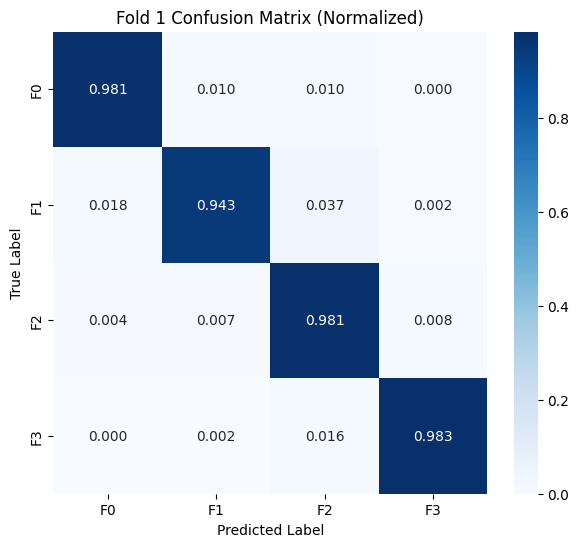


===== Evaluating Fold 2/3 =====
Dataset created with 3618 images.
Running predictions for Fold 2...


Predicting Fold 2: 100%|██████████| 453/453 [00:55<00:00,  8.11it/s]


Plotting Confusion Matrix for Fold 2...


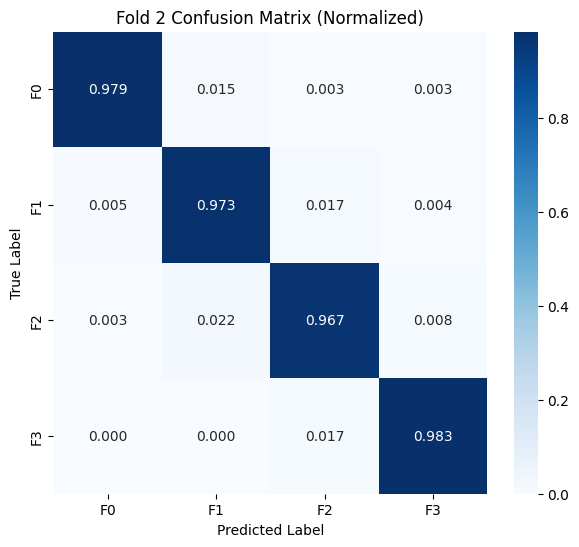


===== Evaluating Fold 3/3 =====
Dataset created with 3618 images.
Running predictions for Fold 3...


Predicting Fold 3: 100%|██████████| 453/453 [00:55<00:00,  8.15it/s]


Plotting Confusion Matrix for Fold 3...


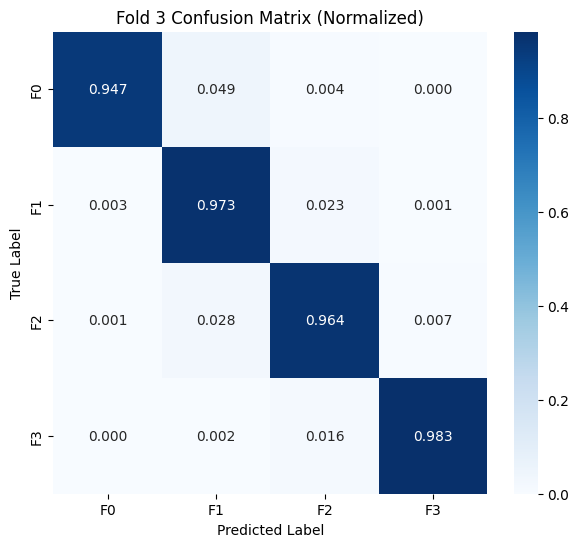


✅ Step 14: All fold predictions are complete and saved.


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F # Import softmax
from tqdm import tqdm

print("🚀 Starting Step 14: Evaluating each fold and getting predictions...")

# Get paths to your saved MRI models
model_paths = [f"mri_fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]

# These lists will store the results from all folds
all_fold_preds = []
all_fold_labels = []
all_fold_probs = [] # We will store probabilities here

# 'splits' variable still exists from Step 10
for fold, (train_idx, valid_idx) in enumerate(splits):
    print(f"\n===== Evaluating Fold {fold+1}/{CFG.N_SPLITS} =====")
    
    valid_df = df.iloc[valid_idx]
    
    # Create dataset and loader for this fold's validation data
    valid_dataset = LiverDataset(valid_df, transform=valid_tfms)
    valid_loader = DataLoader(
        valid_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=2
    )
    
    # Load the trained model for this fold
    model = HybridDenseViT(num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
    model.load_state_dict(torch.load(model_paths[fold], map_location=CFG.DEVICE))
    model.eval()
    
    fold_preds = []
    fold_labels = []
    
    print(f"Running predictions for Fold {fold+1}...")
    with torch.no_grad():
        for images, labels in tqdm(valid_loader, desc=f"Predicting Fold {fold+1}"):
            images = images.to(CFG.DEVICE)
            
            outputs = model(images)
            probs = F.softmax(outputs, dim=1) # Get probabilities
            _, preds = torch.max(outputs, 1)
            
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
            all_fold_probs.extend(probs.cpu().numpy()) # Save probabilities
            
    # Add this fold's results to the master lists
    all_fold_preds.extend(fold_preds)
    all_fold_labels.extend(fold_labels)
            
    # --- Plot Confusion Matrix for THIS FOLD ---
    print(f"Plotting Confusion Matrix for Fold {fold+1}...")
    cm_fold = confusion_matrix(fold_labels, fold_preds)
    cm_norm_fold = cm_fold.astype('float') / cm_fold.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_norm_fold, annot=True, cmap="Blues", fmt=".3f",
                xticklabels=class_map.keys(),
                yticklabels=class_map.keys())
    plt.title(f"Fold {fold+1} Confusion Matrix (Normalized)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# --- Convert lists to numpy arrays for next steps ---
all_fold_labels = np.array(all_fold_labels)
all_fold_preds = np.array(all_fold_preds)
all_fold_probs_np = np.array(all_fold_probs) # Our final probabilities array

print("\n✅ Step 14: All fold predictions are complete and saved.")

In [18]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, confusion_matrix
import numpy as np

print("🚀 Starting Step 15: Calculating Overall Metrics (Report & Specificity)...")

# --- 1. Overall QWK and Accuracy ---
# These are the single most important scores for your model
overall_acc = accuracy_score(all_fold_labels, all_fold_preds)
overall_qwk = cohen_kappa_score(all_fold_labels, all_fold_preds, weights="quadratic")

print("\n===================================================")
print("📊 Overall OOF (Out-of-Fold) Metrics")
print("===================================================")
print(f"Overall Accuracy (all folds combined): {overall_acc:.4f}")
print(f"⭐️ Overall QWK (all folds combined): {overall_qwk:.4f}")

# --- 2. Overall Classification Report ---
print("\n=== Overall Classification Report ===")
print("(Note: Sensitivity = recall)")
print(classification_report(
    all_fold_labels, 
    all_fold_preds, 
    target_names=class_map.keys(), 
    digits=4
))

# --- 3. Calculate and Print Specificity ---
print("\n=== Specificity per Class ===")
cm = confusion_matrix(all_fold_labels, all_fold_preds) # Create the overall matrix

for i, class_name in enumerate(class_map.keys()):
    # Specificity = True Negatives / (True Negatives + False Positives)
    
    # True Negatives (TN) = Sum of all cells NOT in the current class's row or column
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    
    # False Positives (FP) = Sum of the column for this class, minus the true positive
    fp = cm[:, i].sum() - cm[i, i]
    
    # Calculate specificity and handle division by zero
    if (tn + fp) == 0:
        specificity = 1.0
    else:
        specificity = tn / (tn + fp)
    
    print(f"{class_name} (Class {i}) Specificity: {specificity:.4f}")

print("\n✅ Step 15: All text reports are complete.")

🚀 Starting Step 15: Calculating Overall Metrics (Report & Specificity)...

📊 Overall OOF (Out-of-Fold) Metrics
Overall Accuracy (all folds combined): 0.9702
⭐️ Overall QWK (all folds combined): 0.9801

=== Overall Classification Report ===
(Note: Sensitivity = recall)
              precision    recall  f1-score   support

          F0     0.9819    0.9689    0.9754      2185
          F1     0.9628    0.9634    0.9631      3280
          F2     0.9638    0.9707    0.9672      3483
          F3     0.9817    0.9827    0.9822      1906

    accuracy                         0.9702     10854
   macro avg     0.9725    0.9714    0.9720     10854
weighted avg     0.9703    0.9702    0.9703     10854


=== Specificity per Class ===
F0 (Class 0) Specificity: 0.9955
F1 (Class 1) Specificity: 0.9839
F2 (Class 2) Specificity: 0.9828
F3 (Class 3) Specificity: 0.9961

✅ Step 15: All text reports are complete.


🚀 Starting Step 16: Plotting Overall Confusion Matrices...
Plotting Raw Count Confusion Matrix...


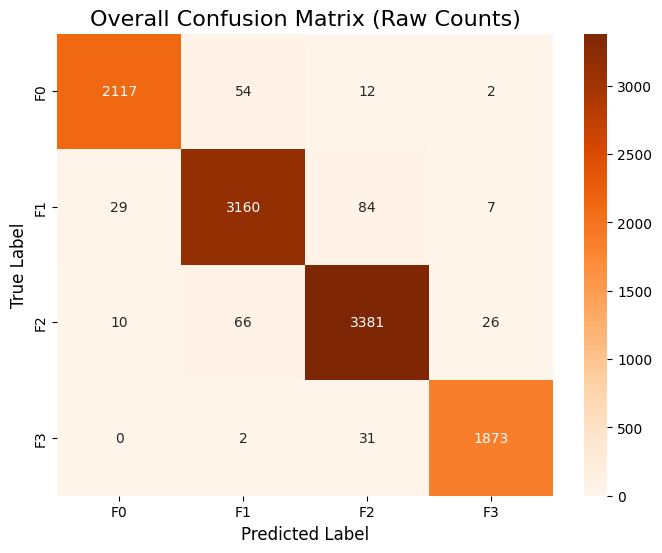


Plotting Normalized Confusion Matrix...


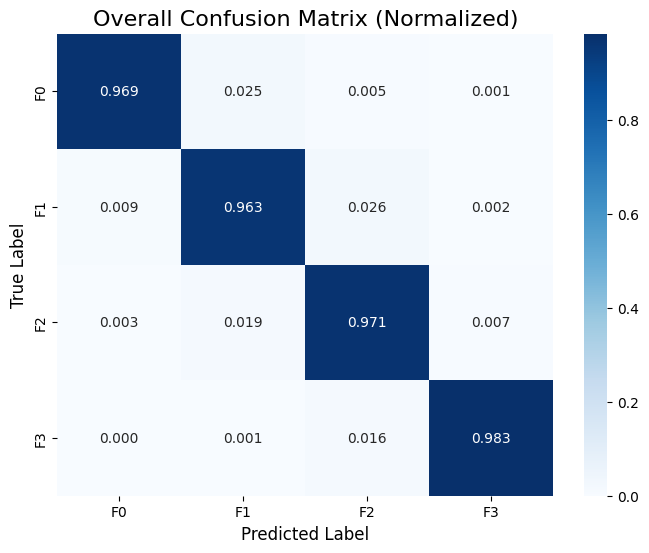


✅ Step 16: Both confusion matrix plots are complete.


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

print("🚀 Starting Step 16: Plotting Overall Confusion Matrices...")

# 'cm' variable still exists in memory from the previous cell (Step 15)

# --- 1. Plot the Overall Confusion Matrix (Raw Counts) ---
print("Plotting Raw Count Confusion Matrix...")
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,     # Show the numbers in each cell
    fmt="d",        # Format the numbers as integers (e.g., "2185")
    cmap="Oranges", # Use an orange color map
    xticklabels=class_map.keys(),
    yticklabels=class_map.keys()
)
plt.title("Overall Confusion Matrix (Raw Counts)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show() # <-- This displays the first plot

# --- 2. Plot the Overall Confusion Matrix (Normalized) ---
print("\nPlotting Normalized Confusion Matrix...")
# Normalize the matrix to get percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm, 
    annot=True,     # Show the numbers in each cell
    fmt=".3f",      # Format the numbers as decimals (e.g., "0.982")
    cmap="Blues",   # Use a blue color map
    xticklabels=class_map.keys(),
    yticklabels=class_map.keys()
)
plt.title("Overall Confusion Matrix (Normalized)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show() # <-- This displays the second plot

print("\n✅ Step 16: Both confusion matrix plots are complete.")

🚀 Starting Step 17: Plotting ROC/AUC Curves...


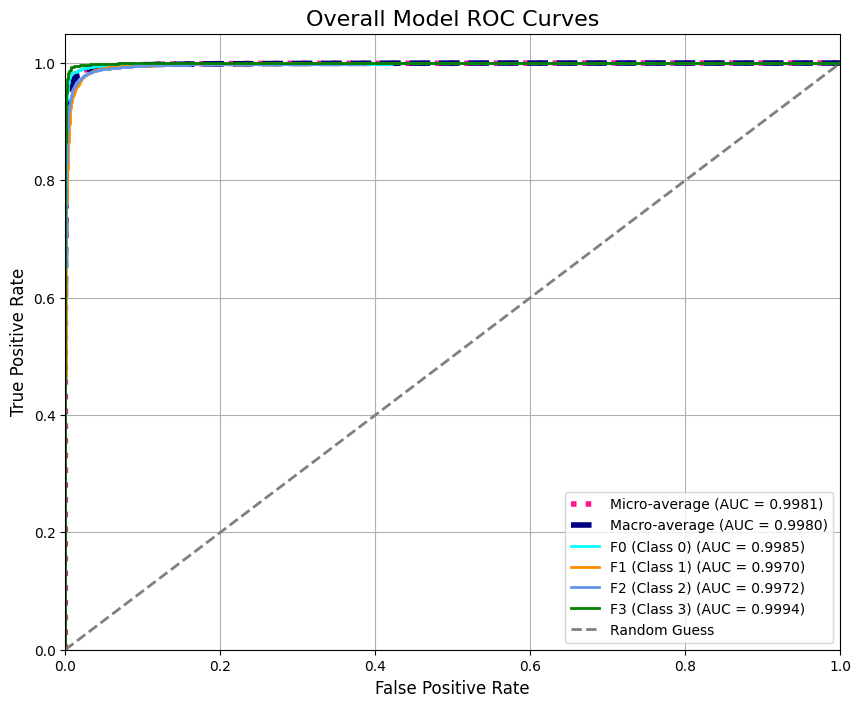


✅ Step 17: ROC/AUC plot complete.


In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("🚀 Starting Step 17: Plotting ROC/AUC Curves...")

# Binarize the true labels (OVR - One-vs-Rest)
# 'all_fold_labels' and 'all_fold_probs_np' were created in Step 14
y_true_bin = label_binarize(all_fold_labels, classes=list(range(CFG.NUM_CLASSES)))
n_classes = CFG.NUM_CLASSES

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_fold_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute Micro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_fold_probs_np.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# --- Compute Macro-average ROC ---
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot all ROC curves ---
plt.figure(figsize=(10, 8)) # Make the plot a bit bigger

# Plot Micro-average
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average (AUC = {roc_auc["micro"]:0.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot Macro-average
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:0.4f})',
         color='navy', linestyle='--', linewidth=4)

# Plot per-class ROC
class_names = list(class_map.keys()) 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green']) # Only 4 colors needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (Class {i}) (AUC = {roc_auc[i]:0.4f})')

# Plot the "random guess" line
plt.plot([0, 1], [0, 1], 'k--', lw=2, color='gray', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Overall Model ROC Curves', fontsize=16)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.show()

print("\n✅ Step 17: ROC/AUC plot complete.")

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

print("🚀 Starting Step 18: Creating the final Ensemble Model...")

# 1. Define the Ensemble Wrapper Class
# This class just holds your 3 trained models
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        # Create a list to hold the 3 models
        self.models = nn.ModuleList()
        
        # Load each of the 3 models into the list
        for path in model_paths:
            # Create a new, untrained model
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            # Load the saved weights from training
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval() # Set to evaluation mode
            self.models.append(model_instance)
        
        print(f"Ensemble loaded with {len(self.models)} models.")

    def forward(self, x):
        # It gets the output (probabilities) from each model
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x)
                probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        
        # Average the probabilities from all 3 models
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs

# 2. Get the paths to your 3 saved models
model_paths = [f"mri_fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
print(f"Found models: {model_paths}")

# 3. Create an instance of the Ensemble Model
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)

# 4. Save the ENTIRE ensemble to a single file
save_path = "ensemble_model_mri.pth"
torch.save(ensemble_model.state_dict(), save_path)

print(f"\n✅ Step 18: Final ensemble MRI model saved successfully to: {save_path}")

🚀 Starting Step 18: Creating the final Ensemble Model...
Found models: ['mri_fold1_best_qwk.pth', 'mri_fold2_best_qwk.pth', 'mri_fold3_best_qwk.pth']
Ensemble loaded with 3 models.

✅ Step 18: Final ensemble MRI model saved successfully to: ensemble_model_mri.pth


In [22]:
import torch
import cv2
import numpy as np

print("🚀 Starting Step 19: Inference test with the final MRI ensemble model...")

# --- 1. Get a random sample image to test ---
sample_row = df.sample(1).iloc[0]
true_label = sample_row.diagnosis
img_path = sample_row.image_path

print(f"Loading random sample image: {os.path.basename(img_path)}")
print(f"True Label: F{true_label}")

# --- 2. Load the image and preprocess it ---
# We use the same pipeline as training
img = preprocess_for_model(img_path)
img_resized = cv2.resize(img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

# Apply validation transforms (Resize, Normalize, ToTensor)
input_tensor = valid_tfms(image=img_resized)["image"].unsqueeze(0).to(CFG.DEVICE)

# --- 3. Load your new ensemble model ---
print("Loading ensemble_model_mri.pth...")
# We must re-define the class for it to load
model_paths = [f"mri_fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
ensemble_model.load_state_dict(torch.load("ensemble_model_mri.pth", map_location=CFG.DEVICE))
ensemble_model.eval() # Set to evaluation mode

# --- 4. Make a prediction ---
with torch.no_grad():
    # The model outputs probabilities (e.g., [0.8, 0.1, 0.05, 0.05])
    probs = ensemble_model(input_tensor)
    
    # Get the highest probability class
    pred_class = torch.argmax(probs, dim=1).item()
    pred_prob = probs.max().item() * 100 # Get the confidence score

print("\n--- Inference Result ---")
print(f"Predicted Label: F{pred_class}")
print(f"Confidence: {pred_prob:.2f}%")

if pred_class == true_label:
    print("✅ Result: Correct!")
else:
    print("❌ Result: Incorrect.")

print("\n✅ Step 19: Inference test complete.")

🚀 Starting Step 19: Inference test with the final MRI ensemble model...
Loading random sample image: 261_t2_slice002.png
True Label: F2
Loading ensemble_model_mri.pth...
Ensemble loaded with 3 models.

--- Inference Result ---
Predicted Label: F2
Confidence: 99.57%
✅ Result: Correct!

✅ Step 19: Inference test complete.


🚀 Starting Step 20: LayerCAM Explainability (Detection)...
Loading ensemble_model_mri.pth to access the sub-models...
LayerCAM objects created.

--- Running on Sample Image ---
Image Path: 261_t2_slice002.png
True Label: F2 | Predicted Label: F2


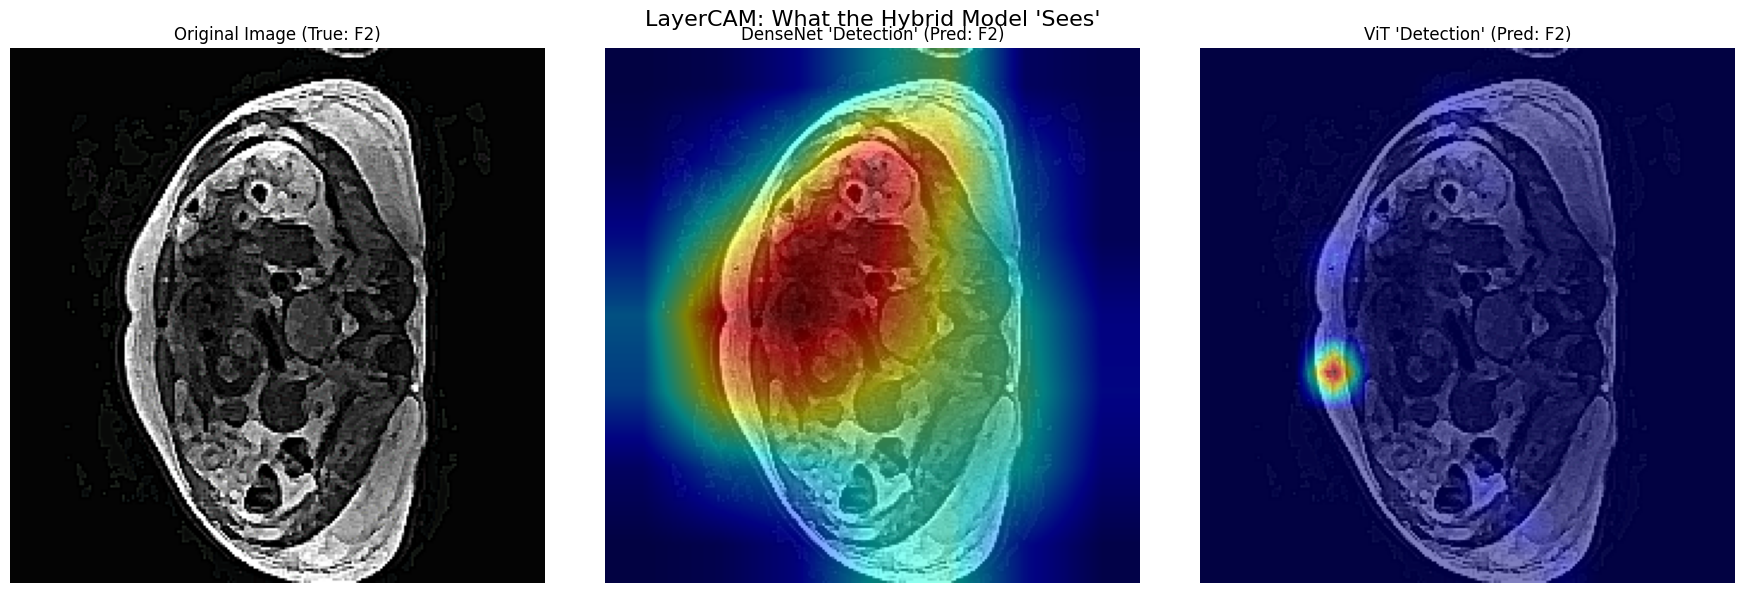


✅ Step 20: LayerCAM detection complete. You have finished the MRI notebook!


In [23]:
import torch
from pytorch_grad_cam import LayerCAM  # <-- Using LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print("🚀 Starting Step 20: LayerCAM Explainability (Detection)...")

# --- 1. This function helps resize ViT's heatmap ---
def reshape_transform_vit(tensor, height=14, width=14):
    # (Batch, 197, 768) -> (Batch, 768, 14, 14)
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- 2. Load your ENSEMBLE model (which contains the sub-models) ---
print("Loading ensemble_model_mri.pth to access the sub-models...")
# We must re-define the EnsembleHybridModel class so torch can load it
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.models = nn.ModuleList()
        for path in model_paths:
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval() # Set to evaluation mode
            self.models.append(model_instance)
        # Note: We don't print here to avoid clutter if re-running
        
    def forward(self, x):
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x)
                probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs
        
model_paths = [f"mri_fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
ensemble_model.load_state_dict(torch.load("ensemble_model_mri.pth", map_location=CFG.DEVICE))
ensemble_model.eval()

# We will run LayerCAM on the first model (Fold 1) inside the ensemble
model_to_explain = ensemble_model.models[0] 

# --- 3. Define the target layers from that sub-model ---
target_layers_cnn = [model_to_explain.cnn.features.norm5]
target_layers_vit = [model_to_explain.vit.blocks[-1].norm1] # Last block of ViT

# --- 4. Create the CAM objects ---
cam_cnn = LayerCAM(model=model_to_explain, 
                  target_layers=target_layers_cnn)

cam_vit = LayerCAM(model=model_to_explain, 
                  target_layers=target_layers_vit,
                  reshape_transform=reshape_transform_vit) # <-- ViT needs this
                  
print("LayerCAM objects created.")

# --- 5. Get the sample image from Step 19 ---
# 'sample_row', 'true_label', 'img_path', 'pred_class', 'input_tensor'
# all still exist in memory from the previous cell
print(f"\n--- Running on Sample Image ---")
print(f"Image Path: {os.path.basename(img_path)}")
print(f"True Label: F{true_label} | Predicted Label: F{pred_class}")

# --- 6. Preprocess the image ---
orig_img = preprocess_for_model(img_path)
orig_img_resized = cv2.resize(orig_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

# --- 7. Generate the heatmaps ---
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam_cnn = cam_cnn(input_tensor=input_tensor, targets=targets)[0, :]
grayscale_cam_vit = cam_vit(input_tensor=input_tensor, targets=targets)[0, :]

# --- 8. Plot the results ---
plot_img = orig_img_resized.astype(np.float32) / 255.0
heatmap_cnn = show_cam_on_image(plot_img, grayscale_cam_cnn, use_rgb=True)
heatmap_vit = show_cam_on_image(plot_img, grayscale_cam_vit, use_rgb=True) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(plot_img)
ax1.set_title(f"Original Image (True: F{true_label})")
ax1.axis('off')

ax2.imshow(heatmap_cnn)
ax2.set_title(f"DenseNet 'Detection' (Pred: F{pred_class})")
ax2.axis('off')

ax3.imshow(heatmap_vit)
ax3.set_title(f"ViT 'Detection' (Pred: F{pred_class})")
ax3.axis('off')

plt.suptitle("LayerCAM: What the Hybrid Model 'Sees'", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Step 20: LayerCAM detection complete. You have finished the MRI notebook!")

🚀 Starting Step 20 (GradCAM Comparison): Explainability...
Loading ensemble_model_mri.pth to access the sub-models...
GradCAM objects created.

--- Running on Sample Image ---
Image Path: 261_t2_slice002.png
True Label: F2 | Predicted Label: F2


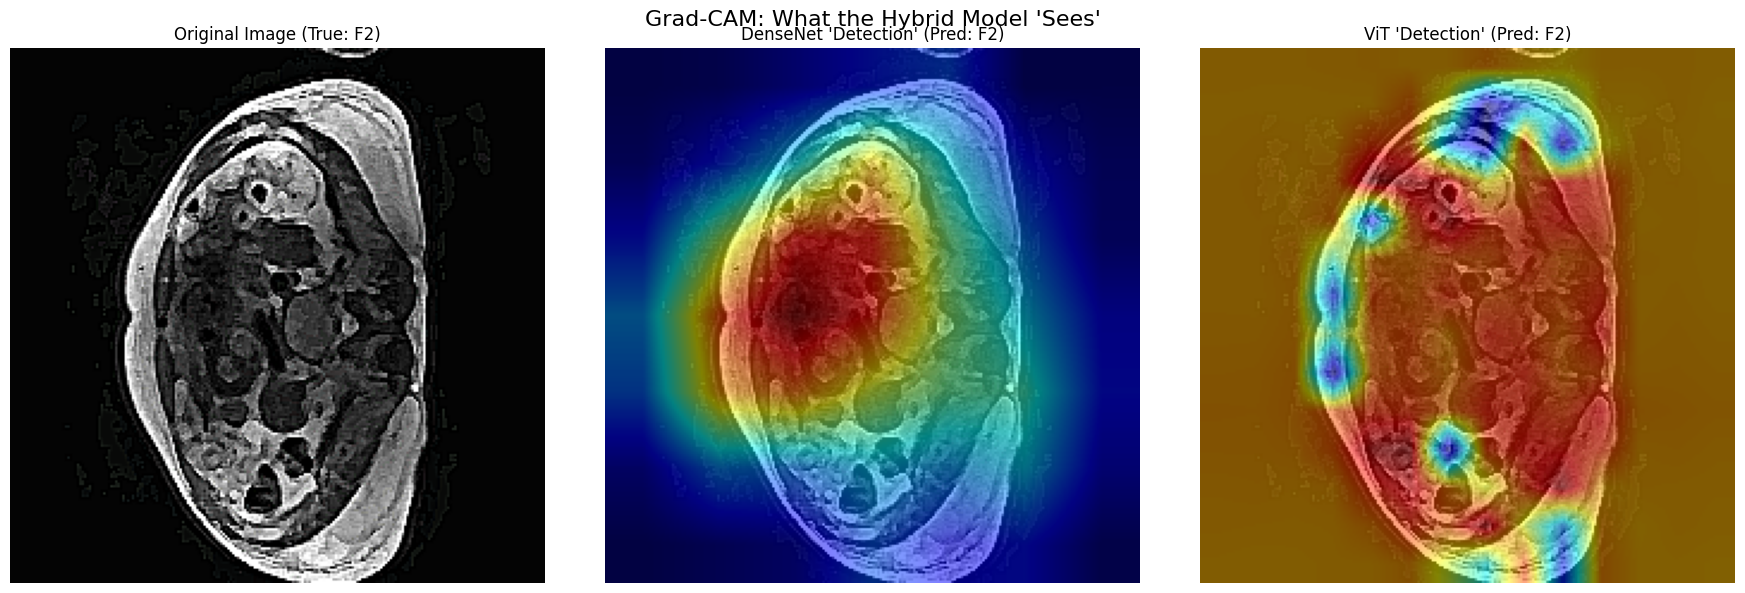


✅ Step 20: Grad-CAM detection complete.


In [24]:
import torch
from pytorch_grad_cam import GradCAM  # <--- CHANGE: Import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print("🚀 Starting Step 20 (GradCAM Comparison): Explainability...")

# --- 1. This function helps resize ViT's heatmap (still needed) ---
def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- 2. Load your ENSEMBLE model (which contains the sub-models) ---
print("Loading ensemble_model_mri.pth to access the sub-models...")
# We must re-define the EnsembleHybridModel class so torch can load it
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.models = nn.ModuleList()
        for path in model_paths:
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval() # Set to evaluation mode
            self.models.append(model_instance)
        # Note: We don't print here to avoid clutter if re-running
        
    def forward(self, x):
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x)
                probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs
        
model_paths = [f"mri_fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
ensemble_model.load_state_dict(torch.load("ensemble_model_mri.pth", map_location=CFG.DEVICE))
ensemble_model.eval()

model_to_explain = ensemble_model.models[0] # Explain using the Fold 1 model

# --- 3. Define the target layers from that sub-model ---
target_layers_cnn = [model_to_explain.cnn.features.norm5]
target_layers_vit = [model_to_explain.vit.blocks[-1].norm1] # Last block of ViT

# --- 4. Create the CAM objects ---
# --- THIS IS THE CHANGE ---
# We are now using GradCAM
cam_cnn = GradCAM(model=model_to_explain, 
                  target_layers=target_layers_cnn)

cam_vit = GradCAM(model=model_to_explain, 
                  target_layers=target_layers_vit,
                  reshape_transform=reshape_transform_vit) # <-- ViT still needs this
# ------------------------
                  
print("GradCAM objects created.")

# --- 5. Get the sample image from Step 19 ---
# 'sample_row', 'true_label', 'img_path', 'pred_class', 'input_tensor'
# all still exist in memory from the previous cell
print(f"\n--- Running on Sample Image ---")
print(f"Image Path: {os.path.basename(img_path)}")
print(f"True Label: F{true_label} | Predicted Label: F{pred_class}")

# --- 6. Preprocess the image ---
orig_img = preprocess_for_model(img_path)
orig_img_resized = cv2.resize(orig_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

# --- 7. Generate the heatmaps ---
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam_cnn = cam_cnn(input_tensor=input_tensor, targets=targets)[0, :]
grayscale_cam_vit = cam_vit(input_tensor=input_tensor, targets=targets)[0, :]

# --- 8. Plot the results ---
plot_img = orig_img_resized.astype(np.float32) / 255.0
heatmap_cnn = show_cam_on_image(plot_img, grayscale_cam_cnn, use_rgb=True)
heatmap_vit = show_cam_on_image(plot_img, grayscale_cam_vit, use_rgb=True) 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(plot_img)
ax1.set_title(f"Original Image (True: F{true_label})")
ax1.axis('off')

ax2.imshow(heatmap_cnn)
ax2.set_title(f"DenseNet 'Detection' (Pred: F{pred_class})")
ax2.axis('off')

ax3.imshow(heatmap_vit)
ax3.set_title(f"ViT 'Detection' (Pred: F{pred_class})")
ax3.axis('off')

plt.suptitle("Grad-CAM: What the Hybrid Model 'Sees'", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Step 20: Grad-CAM detection complete.")

🚀 Starting Step 20 (Final 4-Panel Visualization)...
Loading ensemble_model_mri.pth to access the sub-models...
LayerCAM objects created.

--- Running on Sample Image ---
Image Path: 261_t2_slice002.png
True Label: F2 | Predicted Label: F2


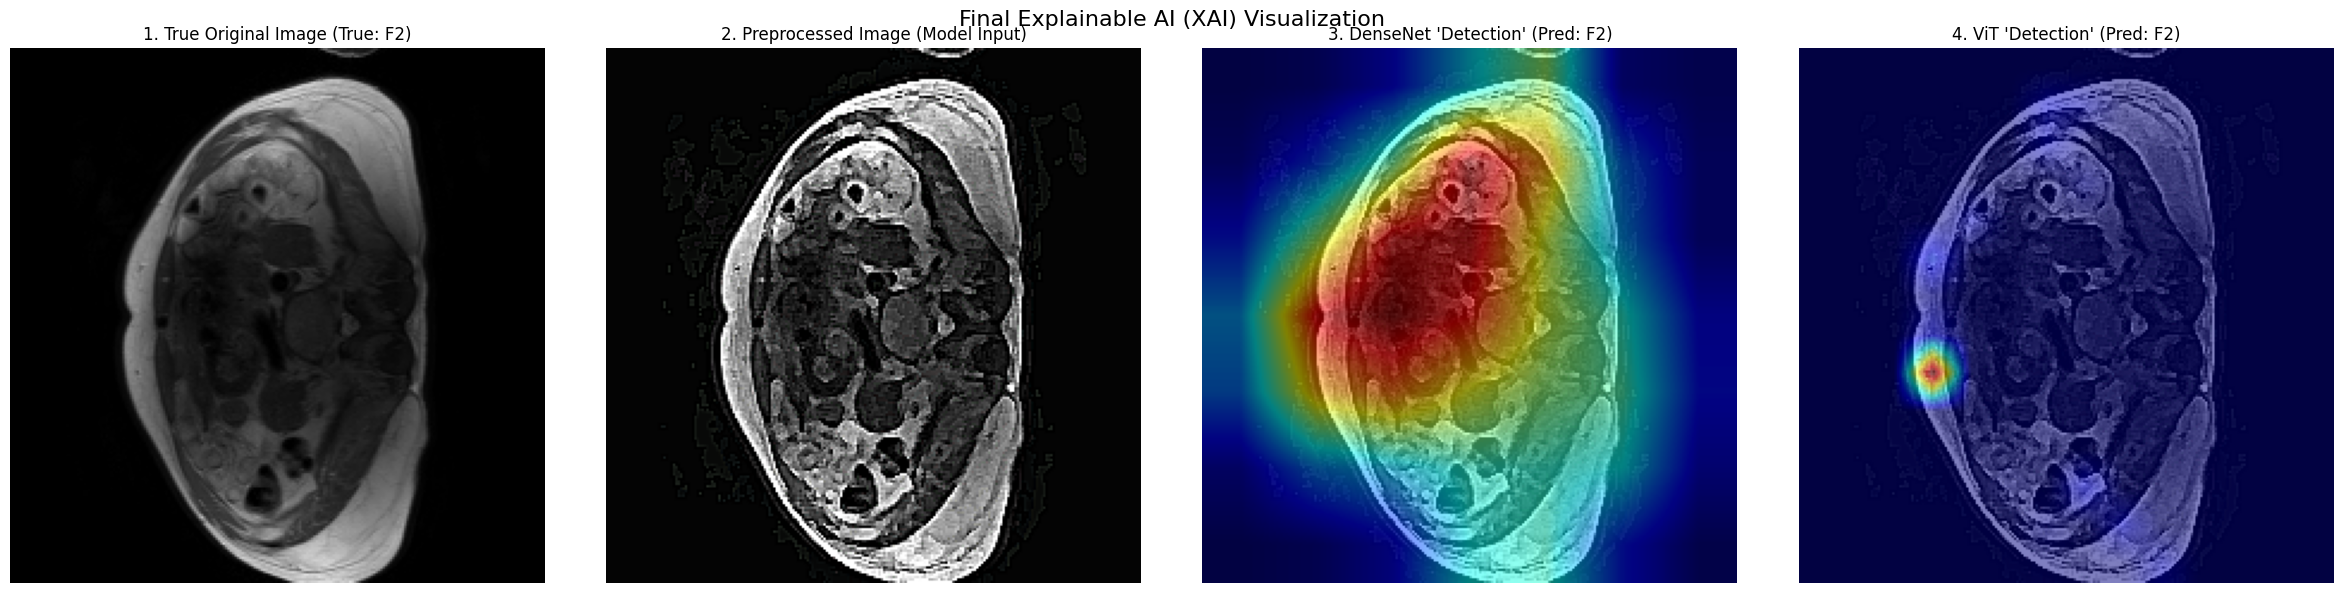


✅ Step 20: Final 4-panel visualization complete.


In [25]:
import torch
from pytorch_grad_cam import LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print("🚀 Starting Step 20 (Final 4-Panel Visualization)...")

# --- 1. ViT reshape function (still needed) ---
def reshape_transform_vit(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

# --- 2. Load your ENSEMBLE model ---
print("Loading ensemble_model_mri.pth to access the sub-models...")
# We must re-define the EnsembleHybridModel class so torch can load it
class EnsembleHybridModel(nn.Module):
    def __init__(self, model_paths, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.models = nn.ModuleList()
        for path in model_paths:
            model_instance = HybridDenseViT(num_classes=self.num_classes)
            model_instance.load_state_dict(torch.load(path, map_location=CFG.DEVICE))
            model_instance.eval()
            self.models.append(model_instance)
        
    def forward(self, x):
        probs_list = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(x); probs = F.softmax(outputs, dim=1)
                probs_list.append(probs)
        avg_probs = torch.mean(torch.stack(probs_list), dim=0)
        return avg_probs
        
model_paths = [f"mri_fold{i+1}_best_qwk.pth" for i in range(CFG.N_SPLITS)]
ensemble_model = EnsembleHybridModel(model_paths, num_classes=CFG.NUM_CLASSES).to(CFG.DEVICE)
ensemble_model.load_state_dict(torch.load("ensemble_model_mri.pth", map_location=CFG.DEVICE))
ensemble_model.eval()

model_to_explain = ensemble_model.models[0] 

# --- 3. Define target layers ---
target_layers_cnn = [model_to_explain.cnn.features.norm5]
target_layers_vit = [model_to_explain.vit.blocks[-1].norm1]

# --- 4. Create LayerCAM objects ---
cam_cnn = LayerCAM(model=model_to_explain, target_layers=target_layers_cnn)
cam_vit = LayerCAM(model=model_to_explain, 
                  target_layers=target_layers_vit,
                  reshape_transform=reshape_transform_vit)
print("LayerCAM objects created.")

# --- 5. Get the sample image from Step 19 ---
# 'sample_row', 'true_label', 'img_path', 'pred_class'
# all still exist in memory from the previous cell
print(f"\n--- Running on Sample Image ---")
print(f"Image Path: {os.path.basename(img_path)}")
print(f"True Label: F{true_label} | Predicted Label: F{pred_class}")

# --- 6. Preprocess the image (NEW: Load two versions) ---
# Version A: The TRUE Original (Just read and resize)
true_original_img = cv2.imread(img_path)
true_original_img = cv2.cvtColor(true_original_img, cv2.COLOR_BGR2RGB)
true_original_img_resized = cv2.resize(true_original_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

# Version B: The PREPROCESSED Image (for the model)
preprocessed_img = preprocess_for_model(img_path)
preprocessed_img_resized = cv2.resize(preprocessed_img, (CFG.IMG_SIZE, CFG.IMG_SIZE))

# Version C: The TENSOR for the model
input_tensor = valid_tfms(image=preprocessed_img_resized)["image"].unsqueeze(0).to(CFG.DEVICE)

# --- 7. Generate the heatmaps ---
targets = [ClassifierOutputTarget(pred_class)]
grayscale_cam_cnn = cam_cnn(input_tensor=input_tensor, targets=targets)[0, :]
grayscale_cam_vit = cam_vit(input_tensor=input_tensor, targets=targets)[0, :]

# --- 8. Plot the 4 results ---
# Normalize preprocessed image for plotting
plot_img_preprocessed = preprocessed_img_resized.astype(np.float32) / 255.0
heatmap_cnn = show_cam_on_image(plot_img_preprocessed, grayscale_cam_cnn, use_rgb=True)
heatmap_vit = show_cam_on_image(plot_img_preprocessed, grayscale_cam_vit, use_rgb=True) 

# Create the 4-panel plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6)) # <-- Now 4 plots

# Plot 1: True Original
ax1.imshow(true_original_img_resized)
ax1.set_title(f"1. True Original Image (True: F{true_label})")
ax1.axis('off')

# Plot 2: Preprocessed Image
ax2.imshow(plot_img_preprocessed)
ax2.set_title(f"2. Preprocessed Image (Model Input)")
ax2.axis('off')

# Plot 3: DenseNet Heatmap
ax3.imshow(heatmap_cnn)
ax3.set_title(f"3. DenseNet 'Detection' (Pred: F{pred_class})")
ax3.axis('off')

# Plot 4: ViT Heatmap
ax4.imshow(heatmap_vit)
ax4.set_title(f"4. ViT 'Detection' (Pred: F{pred_class})")
ax4.axis('off')

plt.suptitle("Final Explainable AI (XAI) Visualization", fontsize=16)
plt.tight_layout()
plt.show()

print("\n✅ Step 20: Final 4-panel visualization complete.")

In [26]:
import os
from IPython.display import FileLink

print("🚀 Starting Step 21: Saving all MRI models permanently...")

# Define the name for your zip file
zip_file_name = "mri_hybrid_models.zip"

# Create a list of all the model files you created
files_to_save = [
    "mri_fold1_best_qwk.pth",
    "mri_fold2_best_qwk.pth",
    "mri_fold3_best_qwk.pth",
    "ensemble_model_mri.pth" # Your final combined model
]

# Check which files actually exist
existing_files = [f for f in files_to_save if os.path.exists(f)]
print(f"Found {len(existing_files)} model files to save.")

if len(existing_files) == 4:
    # Create the zip command
    zip_command = f"zip -r {zip_file_name} {' '.join(existing_files)}"
    
    print(f"Creating zip file: {zip_file_name}...")
    # Run the zip command in the terminal
    !{zip_command}
    
    print("\n✅ Zip file created successfully!")
    print("---")
    print("👇👇👇 TO DOWNLOAD: 👇👇👇")
    print("1. Look at the 'Output' section in the right-hand panel.")
    print(f"2. Find the file '{zip_file_name}'.")
    print("3. Click the three dots (...) and select 'Download'.")
    
    # You can also try clicking this link:
    display(FileLink(zip_file_name))
else:
    print(f"⚠️ ERROR: Could not find all 4 .pth files. Did you run Step 10, 11, 12, 13, and 18?")

🚀 Starting Step 21: Saving all MRI models permanently...
Found 4 model files to save.
Creating zip file: mri_hybrid_models.zip...
  adding: mri_fold1_best_qwk.pth (deflated 7%)
  adding: mri_fold2_best_qwk.pth (deflated 7%)
  adding: mri_fold3_best_qwk.pth (deflated 7%)
  adding: ensemble_model_mri.pth (deflated 7%)

✅ Zip file created successfully!
---
👇👇👇 TO DOWNLOAD: 👇👇👇
1. Look at the 'Output' section in the right-hand panel.
2. Find the file 'mri_hybrid_models.zip'.
3. Click the three dots (...) and select 'Download'.


/kaggle/working/mri_hybrid_models.zip